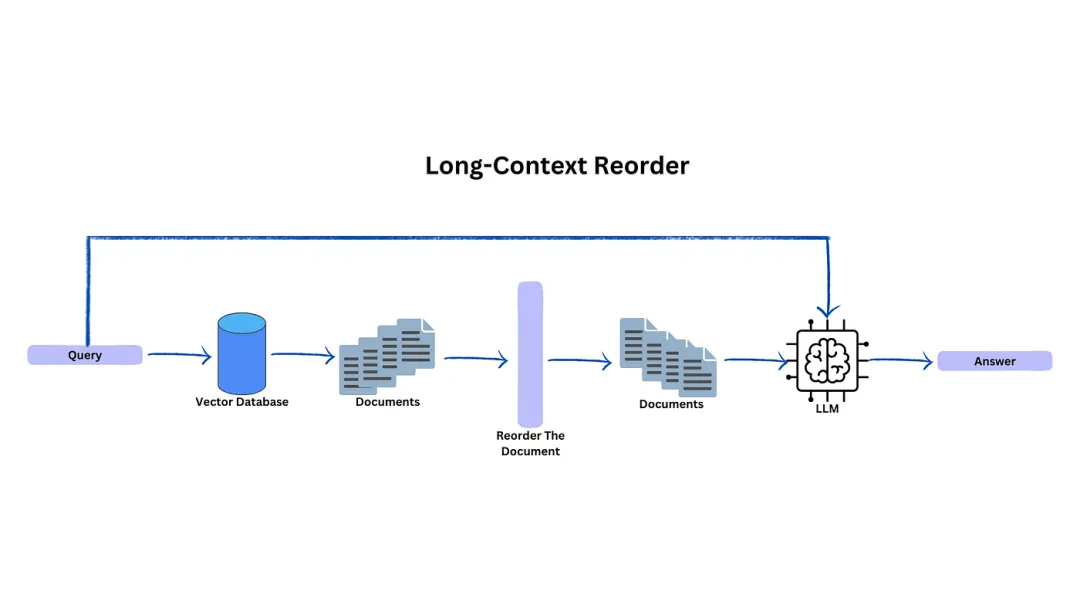

长上下文重排序非常适合于我们想要从矢量数据库返回10个以上文档的情况。为什么我们需要召回那么多文件？也许，我们的块很短，矢量数据库存储了很多块。

当LLM对这么多文档提出问题时，在某些情况下，LLM无法理解位于检索文档中间的文档的上下文。

思路来自论文《Lost in the Middle: How Language Models Use Long Contexts》

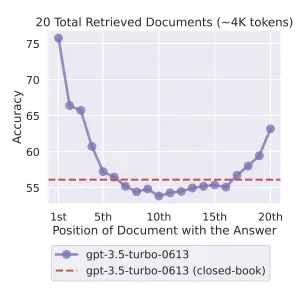

Langchain提供了对应的函数来解决上述问题，该函数可以帮助重新排序相关文档，这样可以确保相关文档位于文档列表的开头和末尾。

In [1]:
!pip install langchain langchain_community openai chromadb tiktoken langchainhub sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.1/324.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
# 设置OpenAI KEY环境变量
import os
import getpass
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

OpenAI API Key:··········


In [3]:
#-------------------------------Prepare Vector Database----------------------
# Build a sample vectorDB
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
import os

In [4]:
# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [5]:
#--------------------------------QnA Part and Reordering------------------------------------
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_transformers import (
    LongContextReorder,
)

llm = ChatOpenAI()

qa_system_prompt = """
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("human", "{question}"),
    ]
)

def format_docs(docs):
    #Called the reordering function in here
    reordering = LongContextReorder()
    reordered_docs = reordering.transform_documents(docs)
    doc_strings = [doc.page_content for doc in reordered_docs]
    return "\n\n".join(doc_strings)


rag_chain = (
    {"context": vectordb.as_retriever() | format_docs, "question": RunnablePassthrough()}
    | qa_prompt
    | llm
    | StrOutputParser()
)
rag_chain.invoke("What are the approaches to Task Decomposition?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


'The approaches to Task Decomposition can vary depending on the specific requirements of the system or problem being addressed. Some common approaches include:\n\n1. Hierarchical Task Decomposition: This approach involves breaking down a complex task into smaller subtasks in a hierarchical manner, where each subtask contributes to the completion of the overall task.\n\n2. Sequential Task Decomposition: In this approach, tasks are decomposed in a sequential order, with each subtask being completed one after the other until the overall task is achieved.\n\n3. Parallel Task Decomposition: Tasks are decomposed into subtasks that can be executed concurrently or in parallel, allowing for faster completion of the overall task.\n\n4. Iterative Task Decomposition: This approach involves breaking down tasks into subtasks that may need to be repeated or iterated over multiple times until the overall task is completed.\n\n5. Functional Task Decomposition: Tasks are decomposed based on their functi